# Number of studies per trait type

## Data preparation

In [1]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt


In [ ]:
!rsync -rpltvz --delete rsync.ebi.ac.uk::pub/databases/opentargets/platform/25.03/output/disease ../../data/.


receiving incremental file list
disease/
disease/disease.parquet

sent 51 bytes  received 4.775.801 bytes  3.183.901,33 bytes/sec
total size is 4.797.202  speedup is 1,00


In [2]:
therapeutic_areas = pl.read_parquet("../../data/therapeutic_areas/*.parquet")


## Quant vs binary

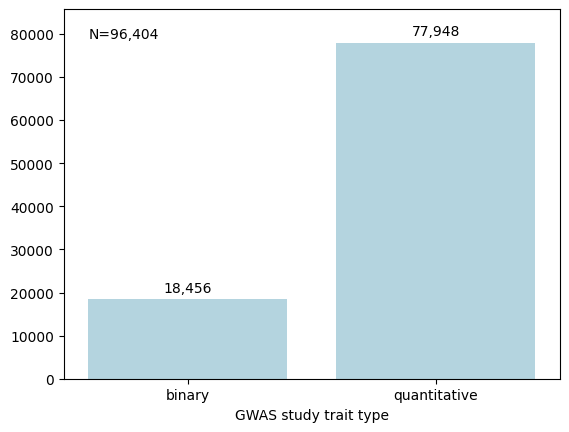

In [32]:
data = (
    therapeutic_areas.select("Measurement", "studyId")
    .group_by("Measurement")
    .len()
    .sort("Measurement")
    .with_columns(
        pl.when(pl.col("Measurement") == 1)
        .then(pl.lit("quantitative"))
        .otherwise(pl.lit("binary"))
        .alias("Measurement")
    )
)
ax = sns.barplot(data=data, x="Measurement", y="len", color="lightblue")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{round(x):,}", padding=3)

ax.set_ylim(0, data["len"].max() * 1.1)
ax.set_ylabel("")
ax.set_xlabel("GWAS study trait type")
ax.text(
    x=0.05,
    y=0.95,
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    s=f"N={data['len'].sum():,}",
)
plt.show()


## Therapeutic area breakdown

/tmp/ipykernel_249235/2523869029.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


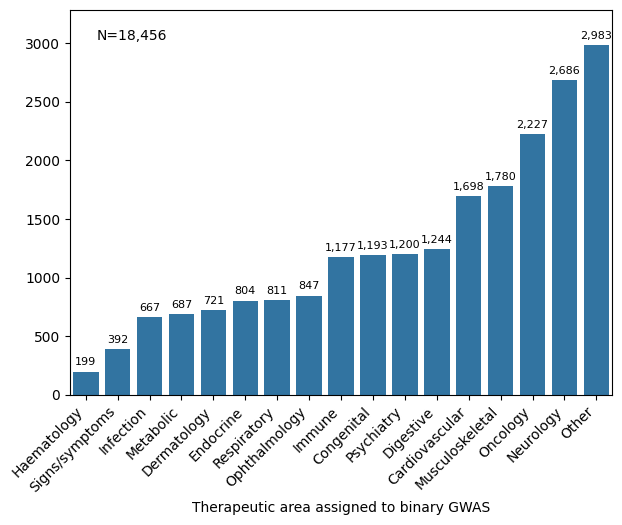

In [52]:
groups = [
    "Cardiovascular",
    "Congenital",
    "Dermatology",
    "Digestive",
    "Endocrine",
    "Haematology",
    "Immune",
    "Infection",
    "Metabolic",
    "Musculoskeletal",
    "Neurology",
    "Oncology",
    "Ophthalmology",
    "Other",
    "Psychiatry",
    "Respiratory",
    "Signs/symptoms",
]

data = (
    therapeutic_areas.unpivot(
        index=["Measurement", "studyId"], on=groups, variable_name="therapeuticArea", value_name="value"
    )
    .group_by("therapeuticArea")
    .agg(pl.sum("value"))
    .sort("value")
)
data
N = therapeutic_areas["Measurement"].count() - therapeutic_areas["Measurement"].sum()

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=data, x="therapeuticArea", y="value", ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{round(x):,}", padding=3, fontsize=8)

ax.set_ylim(0, data["value"].max() * 1.1)
ax.set_ylabel("")
ax.set_xlabel("Therapeutic area assigned to binary GWAS")
ax.text(
    x=0.05,
    y=0.95,
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    s=f"N={N:,}",
)
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

fig.show()


In [ ]:
therapeutic_areas["Haematology"].sum()


199

## Look for Other trait

In [ ]:
other_therapeutic_areas = therapeutic_areas.filter(pl.col("Other") == 1).select(
    pl.col("traitFromSourceMappedIds").list.explode()
)


In [ ]:
disease = pl.read_parquet("../../data/disease/*.parquet")


In [ ]:
pl.Config.set_fmt_str_lengths(1000)
other_therapeutic_areas.join(
    disease.select(pl.col("id"), pl.col("description")),
    left_on="traitFromSourceMappedIds",
    right_on="id",
    how="left",
).group_by("traitFromSourceMappedIds").agg(pl.len(), pl.col("description").first()).sort("len")


traitFromSourceMappedIds,len,description
str,u32,str
"""HP_0033792""",1,null
"""HP_0001880""",1,"""Increased count of eosinophils in the blood."""
"""HP_0025423""",1,"""Any anomaly of the structure of the larynx."""
"""HP_0001788""",1,"""Premature rupture of membranes (PROM) is a condition which occurs in pregnancy when the amniotic sac ruptures more than an hour before the onset of labor."""
"""EFO_0009336""",1,"""Velopharyngeal dysfunction (VPD) occurs when the muscular soft palate (velum) and lateral pharyngeal walls are physically unable to separate the oral and nasal cavities during speech production leading to hypernasality and abnormal speech reduction."""
…,…,…
"""EFO_0008546""",51,"""A condition or physical state produced by the ingestion, injection, inhalation of or exposure to a deleterious agent."""
"""EFO_0009658""",69,"""An undesired harmful effect resulting from a medication or other intervention such as surgery."""
"""EFO_0002571""",88,"""An activity that produces an effect, or that is intended to alter the course of a disease in a patient or population. This is a general term that encompasses the medical, social, behavioral, and environmental acts that can have preventive, therapeutic, or palliative effects."""
